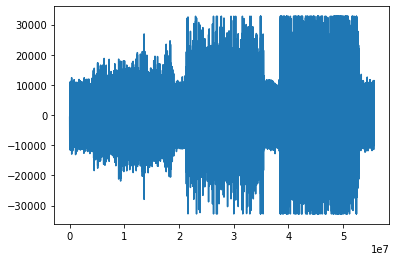

In [28]:
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt

sample_rate, signal = scipy.io.wavfile.read('0606_exp_actlevel.wav')  # File assumed to be in the same directory
# signal = signal[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds
plt.plot(signal)

In [29]:
pre_emphasis = 0.97


emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])


frame_size = 0.025
frame_stride = 0.01

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

frames *= numpy.hamming(frame_length)


In [30]:
NFFT = 512

mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

In [31]:
nfilt = 40

low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

In [32]:
filter_banks.shape

(115906, 40)

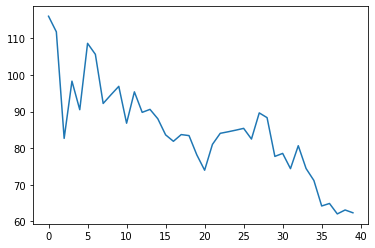

In [33]:
plt.plot(filter_banks[0])

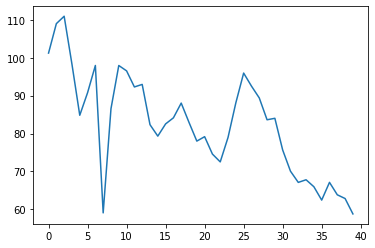

In [34]:
plt.plot(filter_banks[10])

In [35]:
filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)


ValueError: only 1-dimensional arrays can be used

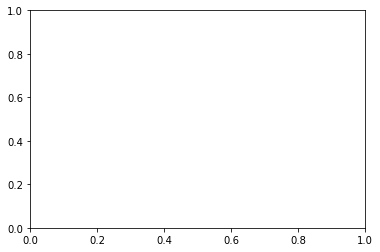

In [37]:
plt.specgram(filter_banks, sample_rate)

In [92]:
import numpy as np

def mfcc_features(path_file, frame_size, frame_stride):
    sample_rate, signal = scipy.io.wavfile.read(path_file)
    signal = signal[:15000]
    pre_emphasis = 0.97
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

    # params
    '''frame_size = 0.025
    frame_stride = 0.01'''
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) +\
        np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # hamming window
    frames *= np.hamming(frame_length)

    NFFT = 512
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    
    num_ceps = 20
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
    
    cep_lifter = 22
    (nframes, ncoeff) = mfcc.shape
    n = np.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift  #*
    
    return filter_banks, mfcc

def normalized_fb(fb):
    fb -= (np.mean(fb, axis=0) + 1e-8)
    return fb

def normalized_mfcc(mfcc):
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    return mfcc

In [93]:
filter_banks, mfcc = mfcc_features('0606_exp_actlevel.wav', frame_size, frame_stride)

In [94]:
filter_banks.shape

(29, 40)

Text(0.5, 1.0, 'Filter Bank')

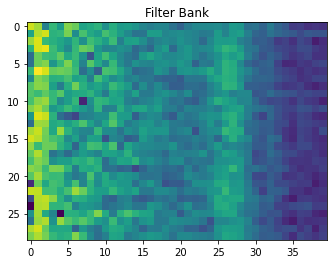

In [96]:
plt.imshow(filter_banks)
plt.title('Filter Bank')

Text(0.5, 1.0, 'Normalized Filter Bank')

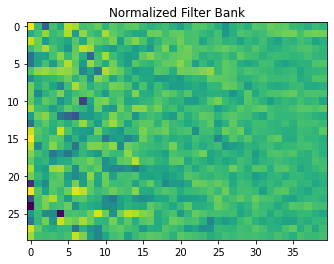

In [97]:
fb_n = normalized_fb(filter_banks)
plt.imshow(fb_n)
plt.title('Normalized Filter Bank')

Text(0.5, 1.0, 'MFCC')

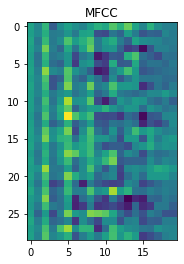

In [98]:
# plt.figure(figsize = mfcc.shape)
plt.imshow(mfcc)
plt.title('MFCC')

In [99]:
import librosa

audio = signal[]
sr = sample_rate
mfcc_l = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T,axis=0)
# chroma
chroma_l = librosa.feature.chroma_stft(S=stft, sr=sr)
chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
# mel
mel_l = librosa.feature.melspectrogram(audio, sr=sr)
mel = np.mean(librosa.feature.melspectrogram(audio, sr=sr).T,axis=0)
# contrast
contrast_l = librosa.feature.spectral_contrast(S=stft, sr=sr)
contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T,axis=0)
# tonnetz
tonnetz_l = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr)
tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr).T,axis=0)


ParameterError: Audio data must be floating-point

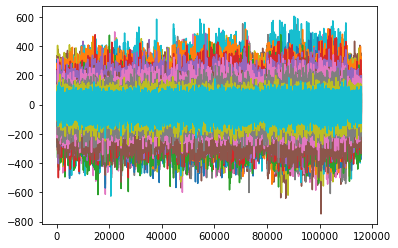

In [66]:
plt.plot(mfcc)


In [63]:
import os
import numpy as np
from subprocess import Popen, PIPE
from bisect import bisect_left

tmp_script = 'tmp.praat'
def gen_script():
    # This generates temporary praat script file
    global tmp_script
    with open(tmp_script, 'w') as f:
        f.write('''
form extract_formant
text FILENAME
positive MAXFORMANT 5500
real WINLEN 0.025
positive PREEMPH 50
endform
Read from file... 'FILENAME$'
To Formant (burg)... 0.01 5 'MAXFORMANT' 'WINLEN' 'PREEMPH'
List... no yes 6 no 3 no 3 no
exit
''')
    return tmp_script
        
def run_praat_cmd(*args):
    o = Popen(['praat'] + [str(i) for i in args],
             shell=False, stdout=PIPE, stderr=PIPE)
    stdout, stderr = o.communicate()
    if os.path.exists(tmp_script): 
        os.remove(tmp_script)
    if o.returncode:
        raise Exception(stderr.decode('utf-8'))
    else:
        return stdout
        
def get_formant(FNAME, time, MAXFORMANT=5500, WINLEN=0.025, PREEMPH=50):
    fmt_out = {}
    def _float(s):
        # Retrieved from https://github.com/mwv/praat_formants_python
        try:
            return float(s)
        except ValueError:
            return np.nan
    key = (FNAME, MAXFORMANT, WINLEN, PREEMPH)
    run_out = run_praat_cmd(gen_script(), FNAME, MAXFORMANT, WINLEN, PREEMPH)
    fmt_out[key] = np.array(list(map(lambda x: list(map(_float, x.rstrip().split('\t')[:4])), 
                                     run_out.decode('utf-8').split('\n')[1:-1])))
    out = fmt_out[key]
    val = out[bisect_left(out[:,0], time), 1:]
    if np.any(np.isnan(val)):
        val = 0.0 # pad nan as 0
    return val

In [65]:
time = 0.5 # sec
get_formant('0606_exp_actlevel.wav', time) # output: F1, F2, F3


FileNotFoundError: [Errno 2] No such file or directory: 'praat'


Shape of Signal: (55635904,)
Signal Datatype: int16
Signal duration: 1159.08 seconds


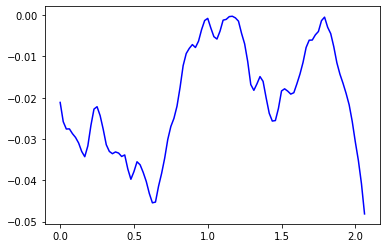

In [74]:
# Using IO module to read Audio Files
from scipy.io import wavfile
freq_sample, sig_audio = wavfile.read('0606_exp_actlevel.wav')
# Output the parameters: Signal Data Type, Sampling Frequency and Duration
print('\nShape of Signal:', sig_audio.shape)
print('Signal Datatype:', sig_audio.dtype)
print('Signal duration:', round(sig_audio.shape[0] / float(freq_sample), 2), 'seconds')

# Normalize the Signal Value and Plot it on a graph
pow_audio_signal = sig_audio / np.power(2, 15)
pow_audio_signal = pow_audio_signal [:100]
time_axis = 1000 * np.arange(0, len(pow_audio_signal), 1) / float(freq_sample)
plt.plot(time_axis, pow_audio_signal, color='blue')

/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_6181/596709417.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  half_length = np.ceil((sig_length + 1) / 2.0).astype(np.int)


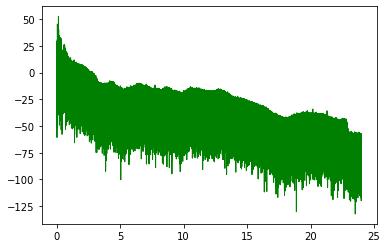

In [75]:
# Working on the same input file
# Extracting the length and the half-length of the signal to input to the foruier transform
sig_length = len(sig_audio)
half_length = np.ceil((sig_length + 1) / 2.0).astype(np.int)
# We will now be using the Fourier Transform to form the frequency domain of the signal
signal_freq = np.fft.fft(sig_audio)
# Normalize the frequency domain and square it
signal_freq = abs(signal_freq[0:half_length]) / sig_length
signal_freq **= 2
transform_len = len(signal_freq)
# The Fourier transformed signal now needs to be adjusted for both even and odd cases
if sig_length % 2:
  signal_freq[1:transform_len] *= 2
else:
  signal_freq[1:transform_len-1] *= 2
# Extract the signal's strength in decibels (dB)
exp_signal = 10 * np.log10(signal_freq)
x_axis = np.arange(0, half_length, 1) * (freq_sample / sig_length) / 1000.0
plt.plot(x_axis, exp_signal, color='green', linewidth=1)


[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip



MFCC Parameters
Window Count = 5
Individual Feature Length = 13


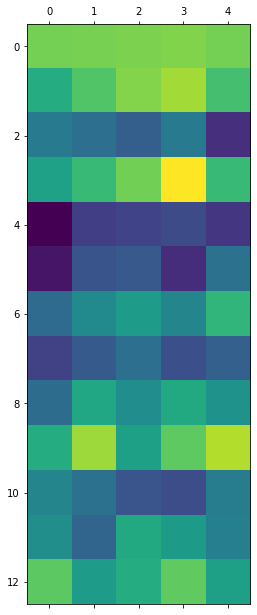

In [110]:
# Installing and importing necessary libraries
!pip install python_speech_features
from python_speech_features import mfcc, logfbank, fbank
sampling_freq, sig_audio = wavfile.read('0606_exp_actlevel.wav')
# We will now be taking the first 15000 samples from the signal for analysis
sig_audio = sig_audio[:3000]
# Using MFCC to extract features from the signal
mfcc_feat = mfcc(sig_audio, sampling_freq)
print('\nMFCC Parameters\nWindow Count =', mfcc_feat.shape[0])
print('Individual Feature Length =', mfcc_feat.shape[1])

mfcc_feat = mfcc_feat.T
plt.matshow(mfcc_feat)



Filter bank
Window Count = 5
Individual Feature Length = 26


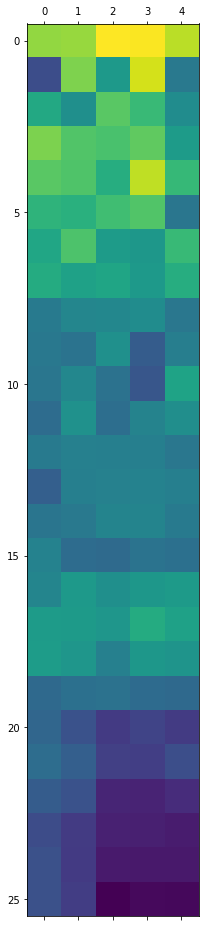

In [111]:
# Generating filter bank features
fb_feat = logfbank(sig_audio, sampling_freq)
print('\nFilter bank\nWindow Count =', fb_feat.shape[0])
print('Individual Feature Length =', fb_feat.shape[1])
fb_feat = fb_feat.T
plt.matshow(fb_feat)

In [112]:
fb_feat.shape

(26, 5)

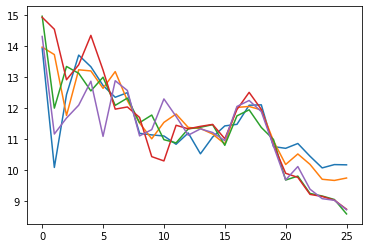

In [113]:
plt.plot(fb_feat)

(5, 26)
(5,)


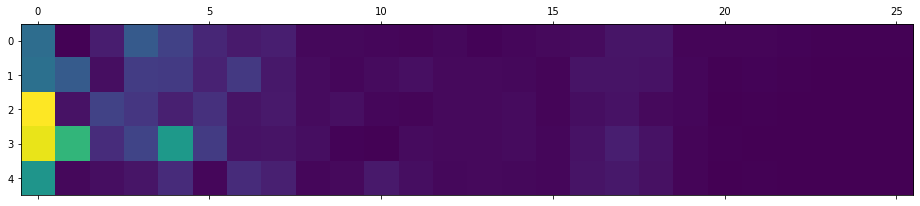

In [115]:
# Generating filter bank features
a, b = fbank(sig_audio, sampling_freq)
print (a.shape)
print(b.shape)
# print('\nFilter bank\nWindow Count =', fb_feat.shape[0])
# print('Individual Feature Length =', fb_feat.shape[1])
# a = fb_feat.T
plt.matshow(a)

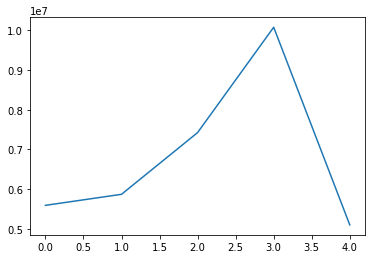

In [119]:
plt.plot(b)

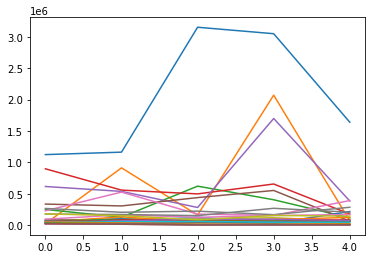

In [120]:
plt.plot(a)

In [6]:
##FORMATS
!pip install scikits.talkbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 2.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [251 lines of output]
      /Users/bchhaglani/miniforge3/lib/python3.9/site-packages/setuptools/dist.py:286: SetuptoolsDeprecationWarning: The namespace_packages parameter is deprecated, consider using implicit namespaces instead (PEP 420).
        warnings.warn(msg, SetuptoolsDeprecationWarning)
      running bdist_wheel
      running build
      running config_cc
      unifing config_cc, config, build_clib, build_ext, build commands --compiler options
      running config_fc
      unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
      running build_src
      build_src
      building library "clpc" sources
      building extension "scikits.talkbox.linpred._lpc" sources
      building extension "scikit

Failed to build scikits.talkbox
  Running setup.py install for scikits.talkbox ... error
  error: subprocess-exited-with-error
  
  × Running setup.py install for scikits.talkbox did not run successfully.
  │ exit code: 1
  ╰─> [249 lines of output]
      /Users/bchhaglani/miniforge3/lib/python3.9/site-packages/setuptools/dist.py:286: SetuptoolsDeprecationWarning: The namespace_packages parameter is deprecated, consider using implicit namespaces instead (PEP 420).
        warnings.warn(msg, SetuptoolsDeprecationWarning)
      running install
      /Users/bchhaglani/miniforge3/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
        warnings.warn(
      running build
      running config_cc
      unifing config_cc, config, build_clib, build_ext, build commands --compiler options
      running config_fc
      unifing config_fc, config, build_clib, build_ext, build

In [28]:
import sys
import numpy
import wave
import math
from scipy.signal import lfilter, hamming
# from scikits.talkbox import lpc
from librosa import lpc
"""
Estimate formants using LPC.
"""


def get_formants(file_path):

    # Read from file.
    spf = wave.open(file_path, 'r') # http://www.linguistics.ucla.edu/people/hayes/103/Charts/VChart/ae.wav
    
    # Get file as numpy array.
    x = spf.readframes(-1)
    x = numpy.fromstring(x, 'int16')

    # Get Hamming window.
    N = len(x)
    w = numpy.hamming(N)

    # Apply window and high pass filter.
    x1 = x * w
#     x1 = lfilter([1., -0.63], 1, x1)
    x1 = lfilter([1], [1., 0.63], x1)

    # Get LPC.
    Fs = spf.getframerate()
    ncoeff = 2 + Fs / 1000
    print(ncoeff)
    A = lpc(x1, int(ncoeff))

#     A = lpc(x1, 8)

    # Get roots.
    rts = numpy.roots(A)
    rts = [r for r in rts if numpy.imag(r) >= 0]

    # Get angles.
    angz = numpy.arctan2(numpy.imag(rts), numpy.real(rts))

    # Get frequencies.
    Fs = spf.getframerate()
    frqs = sorted(angz * (Fs / (2 * math.pi)))

    return frqs

print (get_formants("0606_exp_activtype.wav"))


<bound method Wave_read.readframes of <wave.Wave_read object at 0x17cebb940>>


/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_99101/1145751172.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = numpy.fromstring(x, 'int16')


50.0


/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_99101/1145751172.py:36: FutureWarning: Pass order=50 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  A = lpc(x1, int(ncoeff))


[0.0, 621.7305903178202, 1618.717886133823, 2215.344803963129, 3000.1319301614903, 4541.314301753355, 5354.305769077019, 6543.940807856059, 7362.527557663716, 8474.289923953804, 8999.72362314599, 10457.863644461953, 11263.57064400645, 12336.570840900256, 13074.318324590602, 14055.858293769375, 14990.93433902841, 15967.71511148794, 17111.518183107648, 18288.302153476987, 19055.875781490267, 20147.7678615621, 20561.352493333918, 21741.656530583583, 22654.493734082145, 24000.0]


In [23]:
ncoeff

NameError: name 'ncoeff' is not defined